In [212]:
import pandas as pd
import numpy as np

# Select Transactions from DB

In [213]:
import psycopg2 
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os


load_dotenv()


hostname=os.getenv("hostname")
database=os.getenv("database")
username=os.getenv("username")
pwd=os.getenv("pwd")
port_id=os.getenv("port_id")
host = os.getenv("host")


In [214]:
conn_string = f"postgresql://{username}:{pwd}@{host}:{port_id}/{database}"
db =  create_engine(url=conn_string)
# conn=db.connect()

transactions = pd.read_sql("SELECT * FROM transactions", db)

transactions.head()



,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,id
0,10/28/2022,Joint,MSFT,Microsoft Corporation - Common Stock Option Ty...,Stock Option,Sale (Full),"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/b...,11/10/2022,0
1,10/31/2022,Joint,CLF,Cleveland-Cliffs Inc. Common Stock,Stock,Purchase,"$15,001 - $50,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/b...,11/10/2022,1
2,10/28/2022,Joint,MSFT,Microsoft Corporation - Common Stock Option Ty...,Stock Option,Sale (Full),"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/b...,11/10/2022,2
3,10/28/2022,Joint,MSFT,Microsoft Corporation - Common Stock Option Ty...,Stock Option,Sale (Full),"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/b...,11/10/2022,3
4,10/24/2022,Joint,MSFT,Microsoft Corporation - Common Stock,Stock,Purchase,"$15,001 - $50,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/b...,11/10/2022,4


In [215]:
transactions['dt'] = pd.to_datetime(transactions['transaction_date'])
transactions = transactions.sort_values(by="dt")
earliestDate = transactions.dt.to_list()[0]
earliestDate

Timestamp('2012-06-14 00:00:00')

# Convert API Request to DataFrame

In [216]:
load_dotenv()
import requests
import json 
import asyncio


def requestFromEndpoint(ticker):
    #create endpoint
    apiKey = os.getenv('apiKey')
    endpoint =f"https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY&symbol={ticker}&apikey={apiKey}"

    response = requests.get(endpoint)
    responseText = response.text

    return responseText


def jsonToDataFrame(jsonData, ticker):
    allWeeksData = jsonData['Weekly Time Series']
    allWeeks = list(allWeeksData.keys())

    #convert to df 
    firstWeek = allWeeks[0]
    firstWeekData =allWeeksData[firstWeek ]
    historicalPrices = pd.json_normalize(firstWeekData)
    historicalPrices['date'] = firstWeek

    historicalPrices = historicalPrices.head(0)

    for wk in allWeeks: 
        currentWeekData = allWeeksData[wk]
        currentFrame = pd.json_normalize(currentWeekData)
        currentFrame['date'] = wk
        historicalPrices = pd.concat([historicalPrices, currentFrame])


    # remove oldest values 
    historicalPrices['dt'] = pd.to_datetime(historicalPrices.date)
    historicalPrices[historicalPrices['dt'] > earliestDate]


    #format frame
    historicalPrices.rename(columns={'4. close': ticker}, inplace=True)
    historicalPrices = historicalPrices[[ticker, 'date']]
    historicalPrices[ticker] = historicalPrices[ticker].astype(float)
    
    return historicalPrices




def requestToDataFrame(ticker):
    
    responseText = requestFromEndpoint(ticker)

    jsonData = json.loads(responseText)

    callsExceededMessage = 'Our standard API call frequency is 5 calls per minute and 500 calls per day'
    invalidTickerMessage = 'Invalid API call. Please retry or visit the documentation'
    
    jsonValue_initial = list(jsonData.values())[0]
    if invalidTickerMessage in jsonValue_initial:
        return 'ticker invalid'
    if callsExceededMessage in jsonValue_initial:
        return 'call limit exceeded'
    
    return jsonToDataFrame(jsonData, ticker)



In [217]:
koFrame = requestToDataFrame("KO")
tslaFrame = requestToDataFrame("TSLA")
spyFrame = requestToDataFrame("SPY")

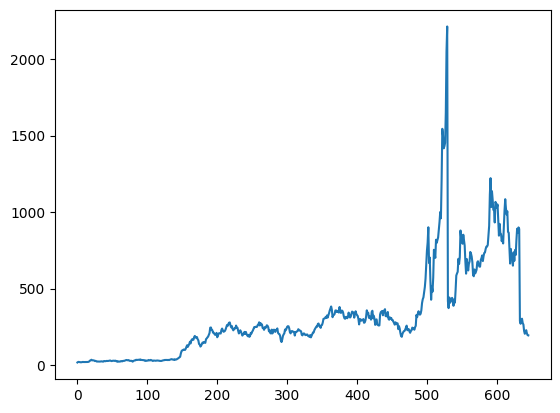

In [218]:
import matplotlib.pyplot as plt

tslaFrame = tslaFrame.sort_values(by="date")
plt.plot(np.array(tslaFrame['TSLA']), linestyle = 'solid')
plt.show()


data requests appear to be working correclty

# Harvest all Stock Data from Endpoint

In [225]:
print(tslaFrame.merge(koFrame, how='left', on='date').shape)
print("NOTE, all week end periods match across requests. so let's make a function for merging ")

(646, 3)
NOTE, all week end periods match across requests. so let's make a function for merging 


In [220]:

def mergeFrames(frame1, frame2):
    rows1 = frame1.shape[0]
    rows2 = frame2.shape[0]
    
    # always merge left against the bigger frame 
    if rows1 >= rows2:
        largeFrame, shortFrame = frame1, frame2
    else: 
        largeFrame, shortFrame = frame2, frame1
    
    rez = largeFrame.merge(shortFrame, how='left', on='date')

    return rez


temp = mergeFrames(koFrame, tslaFrame)
temp = mergeFrames(temp, spyFrame)
temp.tail()

,KO,date,TSLA,SPY
1197,63.25,1999-12-10,NaN,141.8750
1198,68.31,1999-12-03,NaN,143.8437
1199,66.56,1999-11-26,NaN,141.4375
1200,60.50,1999-11-19,NaN,142.5000
1201,57.50,1999-11-12,NaN,139.7500


In [221]:
dateSer = transactions.groupby("ticker")['transaction_date'].min()
allTickers = list(dateSer.index)
allTickers[:5]

['--', '0QZI.IL', '3V64.TI', 'A', 'AA']

In [222]:
dateSer.head()

ticker
--         01/01/2014
0QZI.IL    09/25/2019
3V64.TI    09/25/2019
A          02/24/2015
AA         01/06/2021
Name: transaction_date, dtype: object

In [223]:
# requestToDataFrame('A')